# Libraries

In [69]:
import h5py
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics  import r2_score
from glob             import glob

import matplotlib.pyplot as plt
import scipy.signal      as signal
import torch.nn          as nn
import numpy  			 as np
import pandas 		     as pd


# ECG Definitions

ECG metadata

In [70]:
samplingFrequency = 400

ECG file headers

In [71]:
ecgHeaders = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ECG plot definitions

In [72]:
ecgPlotHeaders = [
	"LI", "aVR", "V1", "V4",
	"LII", "aVL", "V2", "V5",
	"LIII", "aVF", "V3", "V6"
]

ecgPlotColors = {
	"LI":   "seagreen",
	"aVR":  "black",
	"V1":   "gold",
	"V4":   "orangered",
	"LII":  "cornflowerblue",
	"aVL":  "seagreen",
	"V2":   "gold",
	"V5":   "crimson",
	"LIII": "cornflowerblue",
	"aVF":  "cornflowerblue",
	"V3":   "orangered",
	"V6":   "crimson"
}

# The Dataset: CODE-15

Metadata

In [73]:
dataFolder = "../../../data/CODE15/hdf5/"

In [74]:
ecgFeatures = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgFeaturesIndexes = [ecgHeaders.index(derivation) for derivation in ecgFeatures]
ecgFeaturesIndexes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [75]:
ecgTarget = [
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

ecgTargetIndexes = [ecgHeaders.index(derivation) for derivation in ecgTarget]
ecgTargetIndexes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Dataset class

In [76]:
class Code15Dataset(Dataset):
	def __init__(self, hdf5Files, features, target, transform):
		
		super().__init__()
		
		self.hdf5Files = hdf5Files
		self.indexMap  = []
		self.features  = features
		self.target    = target
		self.transform = transform


		for fileIndex, path in enumerate(self.hdf5Files):
			
			with h5py.File(path, "r") as f:
				samplesCount = f['exam_id'].shape[0]
				
				self.indexMap.extend([(fileIndex, i) for i in range(samplesCount)])

	def __len__(self):
		return len(self.indexMap)

	def __getitem__(self, idx):

		fileIndex, examIdx = self.indexMap[idx]
		hdf5File           = self.hdf5Files[fileIndex]

		with h5py.File(hdf5File, "r") as file:
			tracing = np.array(file['tracings'][examIdx])

		tracing = self.transform(tracing)

		X = tracing[:, self.features]
		X = torch.tensor(X, dtype = torch.float32)

		Y = tracing[:, self.target]
		Y = torch.tensor(Y, dtype = torch.float32)

		return X, Y


Transform Function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $ N = 600  $ samples
- Gain of 5
- Normalization with z-score

In [77]:
def transform(ecg):
	b, a = signal.butter(
		N     = 1, 
		Wn    = 1, 
		btype = 'high', 
		fs    = samplingFrequency
	)
	
	ecgFiltred  = signal.filtfilt(b, a, ecg, axis = 0)
	ecgWithGain = 5 * ecgFiltred
	ecgClean    = ecgWithGain[600: -600, :]

	ecgMean = np.mean(ecgClean, axis = 0, keepdims = True)
	ecgStd  = np.std(ecgClean,  axis = 0, keepdims = True) + 1e-8

	ecgNormalized = (ecgClean - ecgMean) / ecgStd

	return ecgNormalized


Holdout dataset

In [78]:
dataset = Code15Dataset(
	hdf5Files = glob(f"{dataFolder}/*.hdf5"),
	features  = ecgFeaturesIndexes,
	target    = ecgTargetIndexes,	
	transform = transform
)

In [79]:
dataset[0][0].shape, dataset[0][1].shape 

(torch.Size([2896, 12]), torch.Size([2896, 12]))

In [80]:
len(dataset)

20001

In [81]:
generator = torch.Generator().manual_seed(14)

In [82]:
trainRatio = 0.80

trainSize = int(trainRatio * len(dataset))
testSize  = len(dataset) - trainSize

print("Train dataset Len =", trainSize)
print("Train dataset Len =", testSize)

Train dataset Len = 16000
Train dataset Len = 4001


In [83]:
trainDataset, testDataset = random_split(
	dataset = dataset,
	lengths = [trainSize, testSize]
)

Dataloaders

In [84]:
trainDataloader = DataLoader(
	dataset     = trainDataset,
	batch_size  = 32,
	shuffle     = True,
	num_workers = 4

)

testDataloader = DataLoader(
	dataset     = testDataset,
	batch_size  = 32,
	shuffle     = False,
	num_workers = 4

)

In [85]:
print("X shape =", dataset[0][0].shape)
print("Y shape =", dataset[0][1].shape)

X shape = torch.Size([2896, 12])
Y shape = torch.Size([2896, 12])


# Model definition

In [86]:
class ECGReconstructor(nn.Module):
	def __init__(self, latentDim=256):
		super(ECGReconstructor, self).__init__()

		self.latentDim = latentDim

		self.encoder = nn.Sequential(
			nn.Conv1d(12, 32, kernel_size=5, stride=2, padding=2),  # (batch, 32, 1448)
			nn.LeakyReLU(0.2),
			nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2), # (batch, 64, 724)
			nn.LeakyReLU(0.2),
			nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2), # (batch, 128, 362)
			nn.LeakyReLU(0.2),
			nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2), # (batch, 256, 181)
			nn.LeakyReLU(0.2),
		)

		self.flattenedSize = 256 * 181

		# Bottleneck
		self.fc_mu 	   = nn.Linear(self.flattenedSize, latentDim)
		self.fc_logvar = nn.Linear(self.flattenedSize, latentDim)

		self.fc_decode = nn.Linear(latentDim, self.flattenedSize)

		self.decoder = nn.Sequential(
			nn.ConvTranspose1d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),  # (batch, 128, 362)
			nn.LeakyReLU(0.2),
			nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),   # (batch, 64, 724)
			nn.LeakyReLU(0.2),
			nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),    # (batch, 32, 1448)
			nn.LeakyReLU(0.2),
			nn.ConvTranspose1d(32, 12, kernel_size=5, stride=2, padding=2, output_padding=1),     # (batch, 9, 2896)
		)

	def encode(self, X):
		X = self.encoder(X)
		X = torch.flatten(X, start_dim = 1)

		mu 	   = self.fc_mu(X)
		logvar = self.fc_logvar(X)
		
		return mu, logvar

	def reparameterize(self, mu, logvar):
		
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		
		return mu + eps * std

	def decode(self, Z):
		Y = self.fc_decode(Z)
		Y = Y.view(-1, 256, 181)
		Y = self.decoder(Y)
		Y = Y.permute(0, 2, 1)
		
		return Y

	def forward(self, X):
		X = X.permute(0, 2, 1)

		mu, logvar = self.encode(X)
		Z 		   = self.reparameterize(mu, logvar)
		YHat 	   = self.decode(Z)

		return YHat, mu, logvar

# Training

Metadata

In [87]:
def vaeLoss(Y, yHat, mean, logvar):
	
	reproductionLoss = nn.functional.mse_loss(yHat, Y)
	KLD 			 = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / Y.shape[0]
	KLD 			 = 1e-3 * KLD

	return reproductionLoss + KLD


In [88]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = ECGReconstructor(latentDim = 256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = vaeLoss
epochs    = 50

print(device)

cuda


Run

In [89]:
trainingLoss = []

In [90]:
model.train()

for epoch in range(epochs):
	totalLoss = 0

	for X, Y in trainDataloader:
		X, Y = X.to(device), Y.to(device)

		YHat, mean, logvar  = model(X)
		loss 				= criterion(Y, YHat, mean, logvar)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		totalLoss += loss.item()

	trainingLoss.append(totalLoss / len(trainDataloader))

	print(f"Epoch {epoch + 1}: loss = {trainingLoss[-1]:.4f}")

Epoch 1: loss = 0.9930
Epoch 2: loss = 0.6679
Epoch 3: loss = 0.5592
Epoch 4: loss = 0.5266
Epoch 5: loss = 0.5014
Epoch 6: loss = 0.4816
Epoch 7: loss = 0.4654
Epoch 8: loss = 0.4519
Epoch 9: loss = 0.4437
Epoch 10: loss = 0.4356
Epoch 11: loss = 0.4299
Epoch 12: loss = 0.4234
Epoch 13: loss = 0.4185
Epoch 14: loss = 0.4136
Epoch 15: loss = 0.4103
Epoch 16: loss = 0.4050
Epoch 17: loss = 0.4010
Epoch 18: loss = 0.3973
Epoch 19: loss = 0.3924
Epoch 20: loss = 0.3901
Epoch 21: loss = 0.3860
Epoch 22: loss = 0.3824
Epoch 23: loss = 0.3790
Epoch 24: loss = 0.3761
Epoch 25: loss = 0.3740
Epoch 26: loss = 0.3714
Epoch 27: loss = 0.3693
Epoch 28: loss = 0.3663
Epoch 29: loss = 0.3645
Epoch 30: loss = 0.3624
Epoch 31: loss = 0.3613
Epoch 32: loss = 0.3581
Epoch 33: loss = 0.3565
Epoch 34: loss = 0.3557
Epoch 35: loss = 0.3538
Epoch 36: loss = 0.3521
Epoch 37: loss = 0.3499
Epoch 38: loss = 0.3488
Epoch 39: loss = 0.3470
Epoch 40: loss = 0.3459
Epoch 41: loss = 0.3447
Epoch 42: loss = 0.3431
E

Loss along the epochs

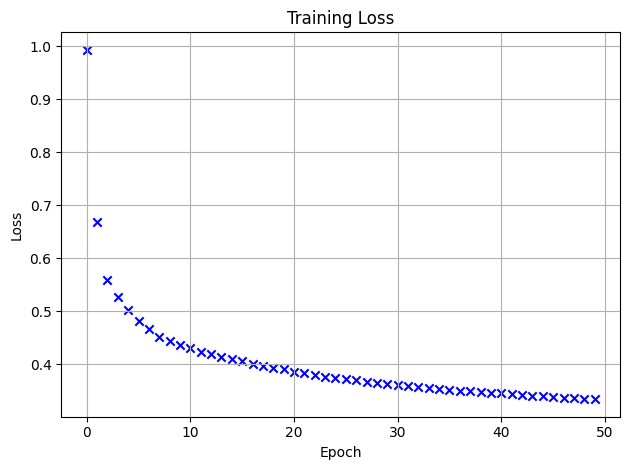

In [91]:
plt.scatter(range(epochs), trainingLoss, c = "blue", marker = "x")

plt.title("Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid()
plt.tight_layout()
plt.show()

# Test

In [92]:
model.eval()

testLoss = 0
testR2   = 0

totalSamples = 0

with torch.no_grad():
	for X, Y in testDataloader:
		X, Y       =  X.to(device), Y.to(device)

		YHat, mean, logvar  = model(X)
		loss 				= criterion(Y, YHat, mean, logvar)

		YFlat    = Y.cpu().numpy().reshape(-1, Y.shape[-1])
		YHatFlat = YHat.cpu().numpy().reshape(-1, YHat.shape[-1])

		testLoss += loss.item()
		testR2   += r2_score(YFlat, YHatFlat) * YFlat.shape[0]

		totalSamples += YFlat.shape[0]

testR2 /= totalSamples

print(f"Test Loss: {testLoss:.4f}")
print(f"Test R^2:  {testR2:.4f}")


Test Loss: 47.9178
Test R^2:  0.7430


# Ploting

Ploting functions

In [93]:
def plotECG(ecg, headers, colors): 
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		axes[idx].plot(ecg[header], color = colors[header])
		axes[idx].set_title(f"{header}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

In [94]:
def comparativeFullEcgPlot(ecgOring, ecgRec, headers):
	figure, axes = plt.subplots(
		nrows   = 3,
		ncols   = 4,
		sharex  = True,
		figsize = (16, 9)
	)

	figure.suptitle("Comparison: ECG 12-Lead")
	figure.supxlabel("Sample")
	figure.supylabel("Dpp")

	axes = axes.flatten()

	for idx, header in enumerate(headers):
		corr = np.round(ecgOring[header].corr(ecgRec[header]), 3)
		r2   = np.round(r2_score(ecgOring[header], ecgRec[header]), 3)

		axes[idx].plot(
			ecgOring[header], 
			color = "blue", 
			alpha = 0.75
		)
		axes[idx].plot(
			ecgRec[header], 
			color = "red", 
			alpha = 0.75
		)

		axes[idx].set_title(f"{header} CORR = {corr} r2 = {r2}")
	

	plt.tight_layout(pad = 1.5)

	plt.show()

	plt.close()

Extract a sample ECG from dataset

In [106]:
sampleECGTensor, _ = trainDataset[0]

sampleECG = pd.DataFrame(
	columns = ecgFeatures,
	data    = sampleECGTensor
)

sampleECG.head()


,LI,LII,LIII,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-0.260911,-0.114254,0.277139,0.236415,-0.287479,0.153210,0.213885,0.159457,-0.165247,-0.206647,-0.254201,-0.396692
1,-0.215130,-0.100524,0.223774,0.176498,-0.216375,0.106996,0.160953,0.125980,-0.211182,-0.233705,-0.306772,-0.469238
2,-0.169979,0.012437,0.245712,0.114849,-0.208496,0.215860,0.097496,0.065273,-0.238540,-0.234694,-0.332899,-0.543245
3,-0.123967,0.189630,0.314634,0.024970,-0.222470,0.399327,0.078229,0.021798,-0.240829,-0.256262,-0.339245,-0.569688
4,-0.103254,0.326415,0.388435,-0.062331,-0.240583,0.601155,-0.017226,-0.048245,-0.308226,-0.328897,-0.425812,-0.637814


In [107]:
with torch.no_grad():
    sampleECGReconstructed, _, _ = model(sampleECGTensor.unsqueeze(0).to(device))
    sampleECGReconstructed       = sampleECGReconstructed.cpu().numpy()
    sampleECGReconstructed       = sampleECGReconstructed.squeeze(0)

sampleECGReconstructed = pd.DataFrame(
    columns = ecgTarget,
    data    = sampleECGReconstructed
)

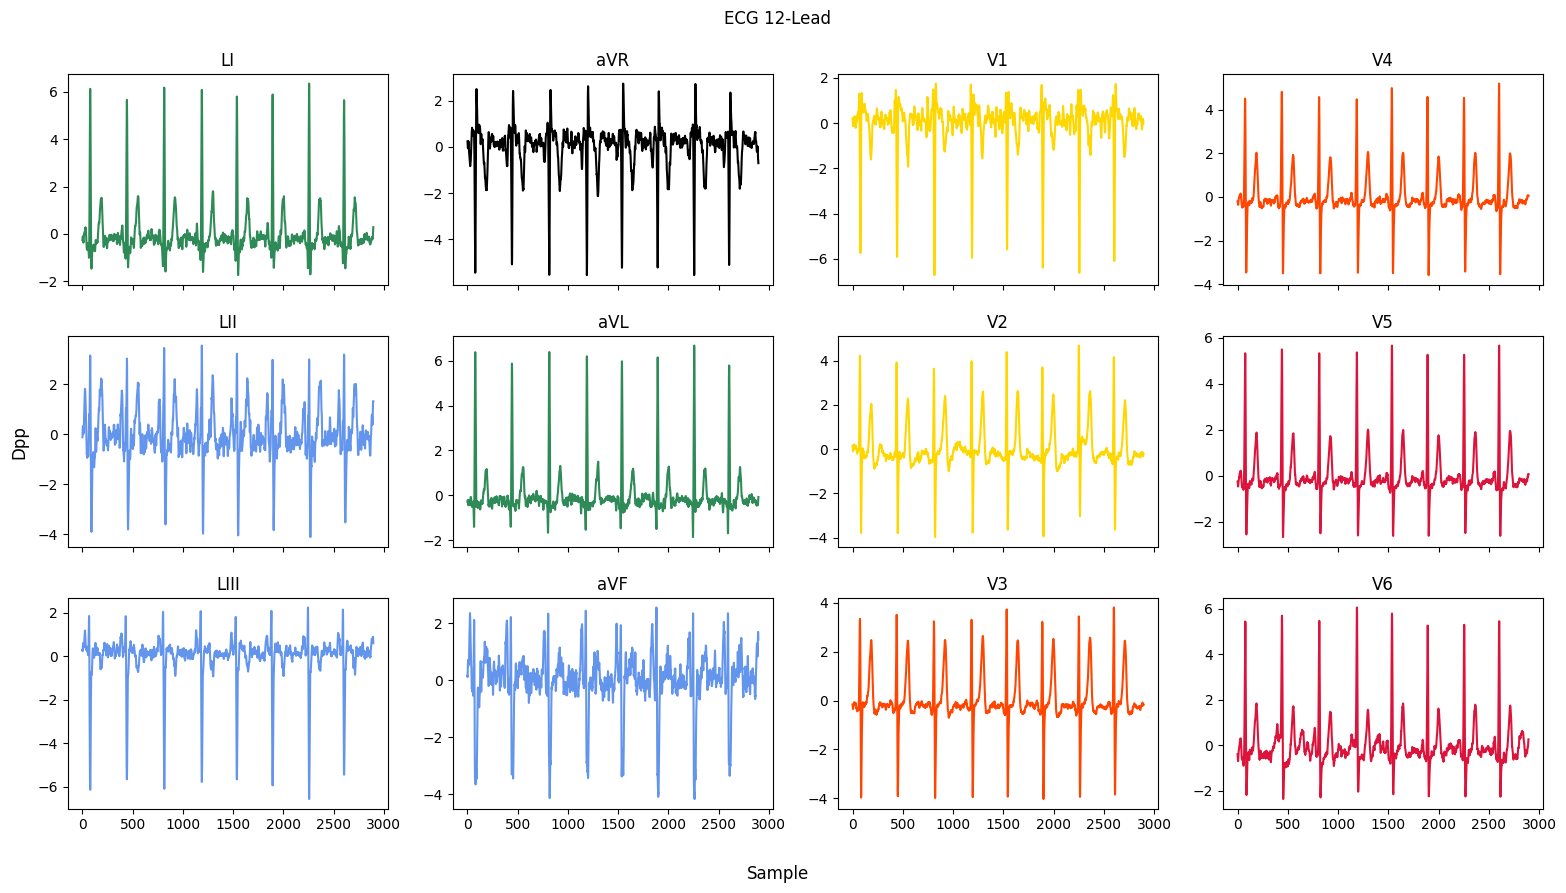

In [108]:
plotECG(
	ecg     = sampleECG,
	headers = ecgPlotHeaders,
	colors  = ecgPlotColors
)

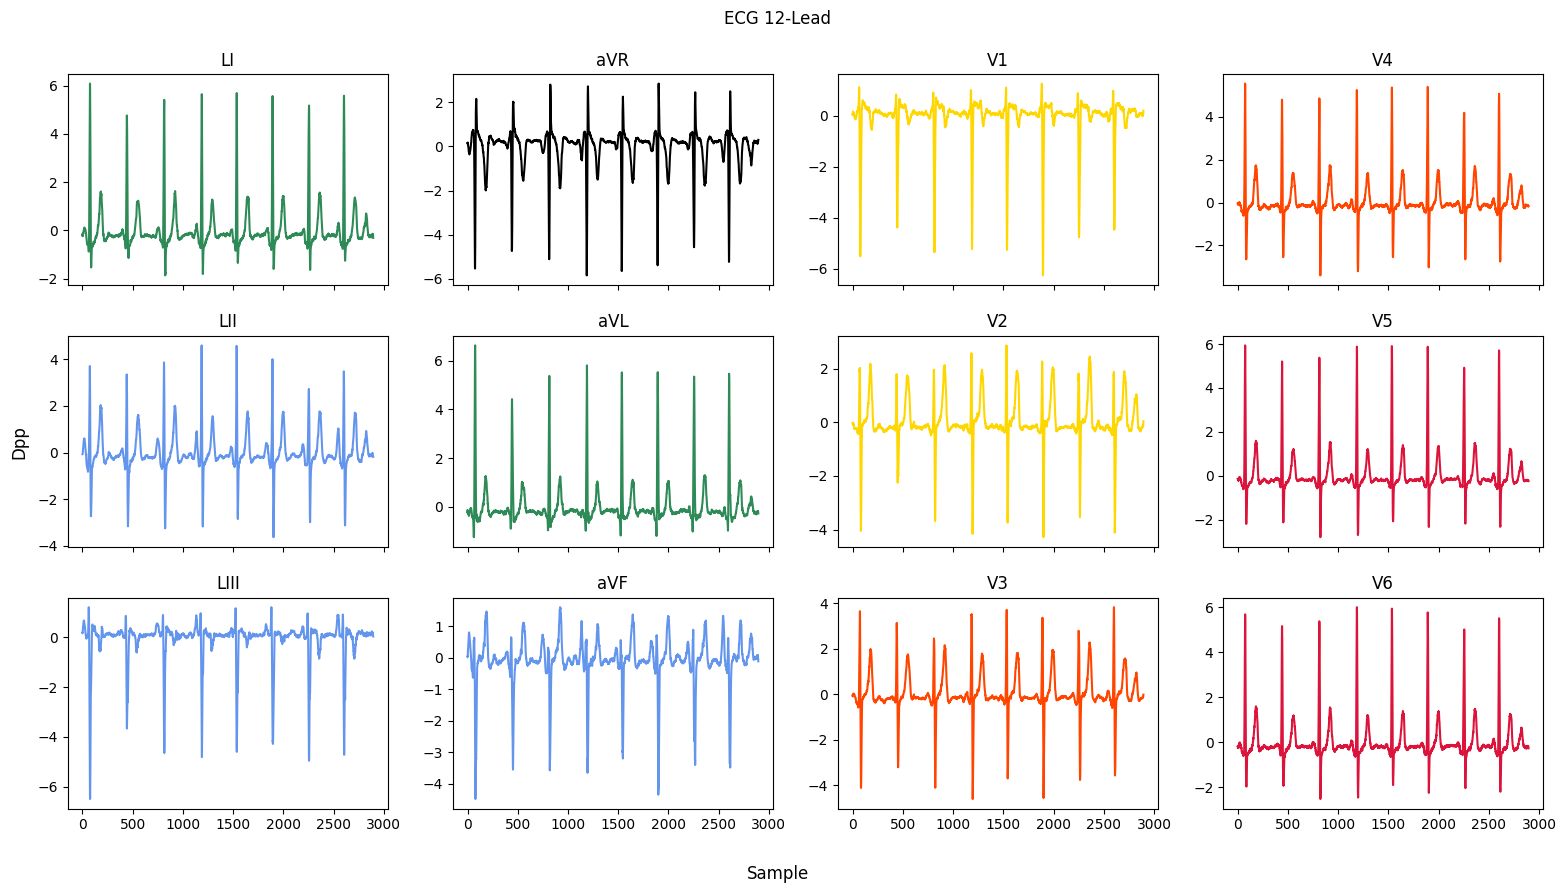

In [109]:
plotECG(
	ecg     = sampleECGReconstructed,
	headers = ecgPlotHeaders,
	colors  = ecgPlotColors
)

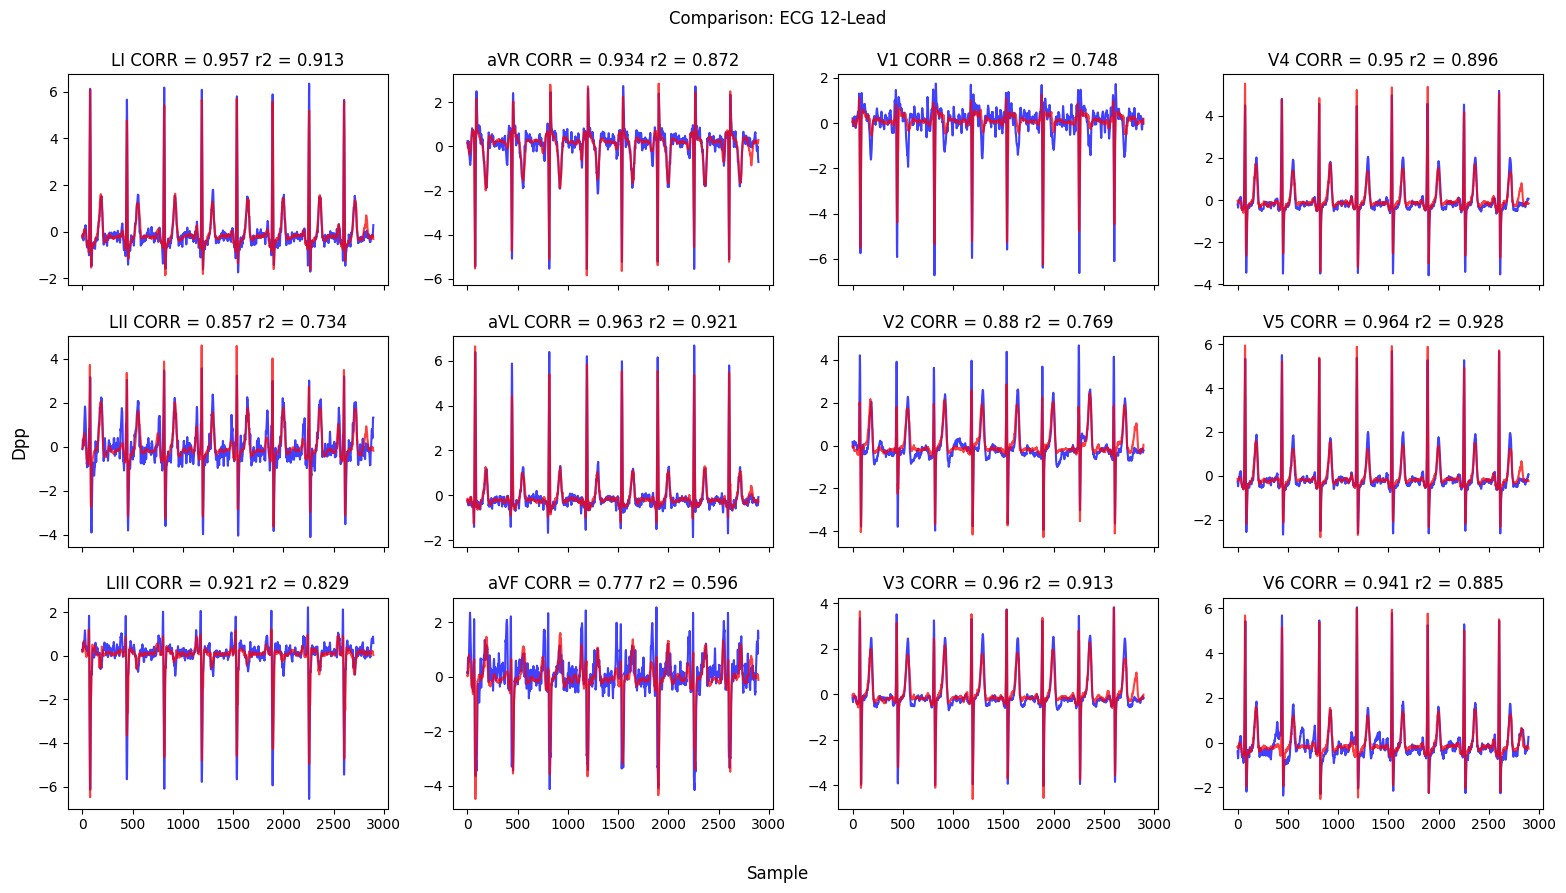

In [110]:
comparativeFullEcgPlot(
	ecgOring = sampleECG,
	ecgRec   = sampleECGReconstructed,
	headers  = ecgPlotHeaders
)

In [111]:
viewWindow = slice(1000, 2000)

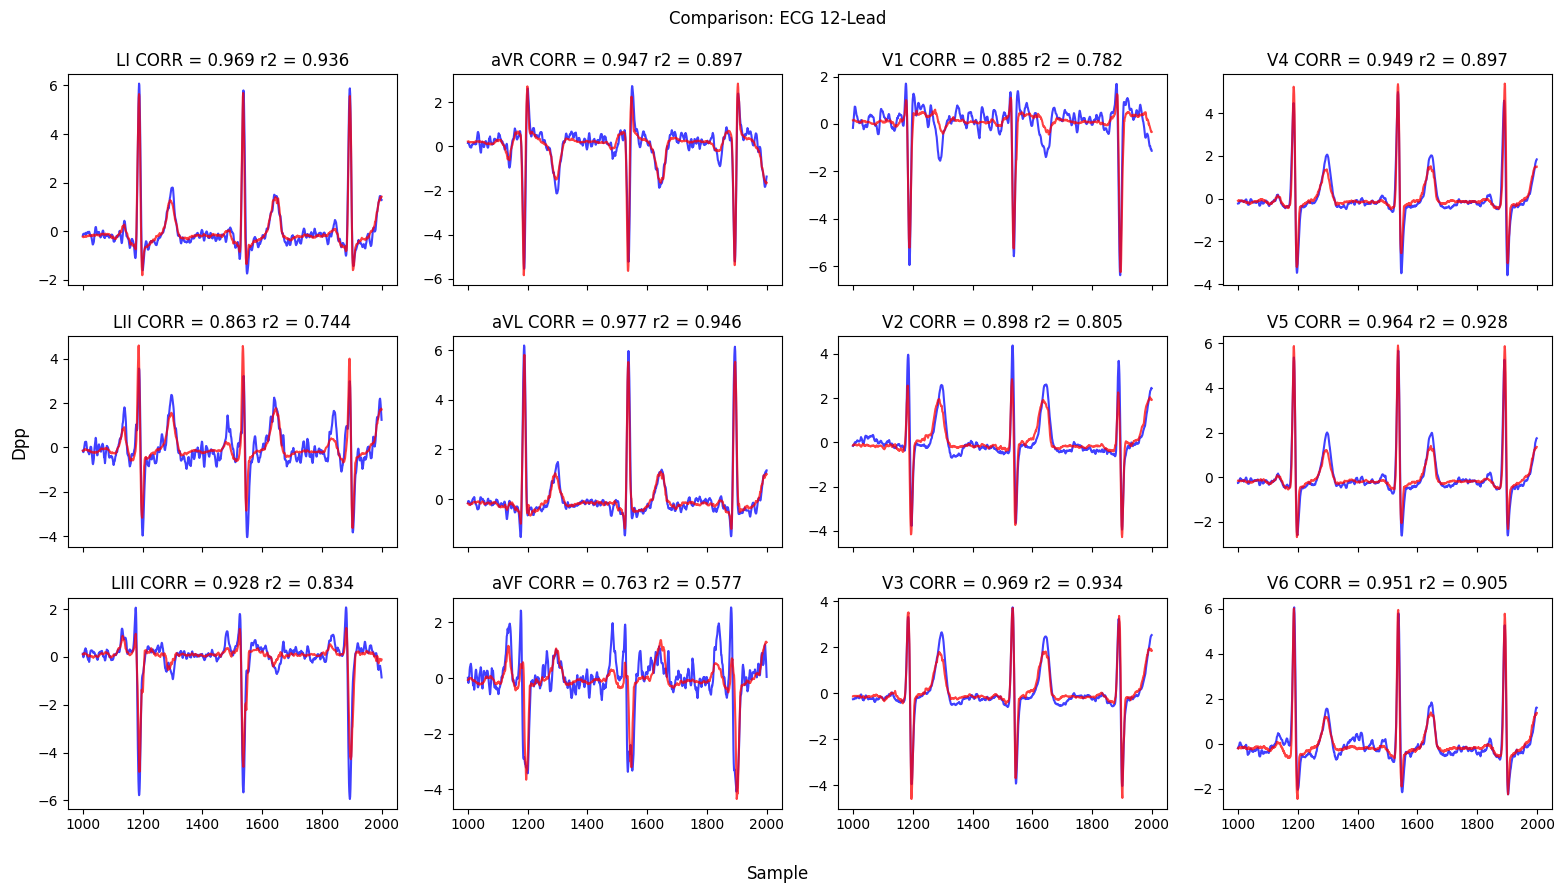

In [112]:
comparativeFullEcgPlot(
	ecgOring = sampleECG[viewWindow],
	ecgRec   = sampleECGReconstructed[viewWindow],
	headers  = ecgPlotHeaders
)

# Save model

In [113]:
torch.save(model.state_dict(), "../../../models/t3/ae-t3-v1.pth")